# Demo-1: Linear Classifiers with Arduino

This is a demonstration for the linear classifiers (SVM and Softmax).

## Arduino Code repository


[https://github.com/auralius/arduino-linear-classifier](https://github.com/auralius/arduino-linear-classifier)

Check the folder with the following name: `usps_16by16`.

![](./images/demo_16by16.gif)

## Preparations

As usual, let's start with some preparations.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)

Put the SVM class and the Softmax class here so that we can use them easily to train our classifier.

### The SVM class

In [12]:
from numba import njit, prange

class SVM():
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def svm_loss(W, X, Y, reg):
        """
        Structured SVM loss function, naive implementation (with loops).

        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n

        """
        X  = np.hstack((X, np.ones((X.shape[0],1)))) # the last column is 1: to allow augmentation of bias vector into W

        dW = np.zeros(W.shape)  # initialize the gradient as zero

        # compute the loss and the gradient
        C = W.shape[1]
        N = X.shape[0]
        loss = 0.0

        F = X@W
        for i in prange(N):
            Fi = F[i]
            Fyi = Fi[Y[i]]
            Li = Fi - Fyi + 1        # 
            Li[np.where(Li < 0)] = 0 # max(0, ...)
            loss += np.sum(np.delete(Li, Y[i]))

            for j in prange(C):         
                if Li[j] > 0 and j != Y[i]:
                    dW[:, j] += X[i]    # update gradient for incorrect label
                    dW[:, Y[i]] -= X[i] # update gradient for correct label

        loss  = loss / N + reg * np.sum(W * W) # add regularization to the loss.
        dW = dW / N + 2 * reg * W # append partial derivative of regularization term

        return loss, dW


    @staticmethod
    def svm_loss_vectorized(W, X, Y, reg):
        """
        Structured SVM loss function, naive implementation (with loops).

        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n

        """
        X  = np.hstack((X, np.ones((X.shape[0],1)))) # the last column is 1: to allow augmentation of bias vector into W
        N = X.shape[0]

        # scores
        F  = X @ W

        # Scores for correct labels
        Fy = F[range(N), Y].reshape(-1,1)

        # compute the loss
        L  = F - Fy + 1
        L  = np.clip(L, a_min=0, a_max=None) # max(0, ...)
        L_ = L.copy() # keep the original
        L[range(N) , Y] = 0 # exclude the correct labels
        loss = np.sum(L) / N + reg * np.sum(W * W)

        # compute the gradient
        dW = (L_ > 0).astype(float) # positive for incorrect labels
        dW[range(N), Y] = dW[range(N), Y] - dW.sum(axis=1) # negative for correct labels
        dW = X.T @ dW / N + 2 * reg * W  # gradient with respect to W

        return (loss, dW)
      

    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True, verbose_step=1000):
        '''
        Train this linear classifier using stochastic gradient descent. 
        Setting the 'batch_size=None" turns of the stochastic feature.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        - verbose_steps: (integer) print proress once every verbose_steps

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        N, D = X.shape
        C = len(np.unique(Y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(D + 1, C) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            if batch_size is not None:
                batch_indices = np.random.choice(N, batch_size, replace=False)
                X_batch = X[batch_indices]
                y_batch = Y[batch_indices]
                loss, grad = self.svm_loss_vectorized(self.W, X_batch, y_batch, reg)
            else:
                loss, grad = self.svm_loss_vectorized(self.W, X, Y, reg)
            
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % verbose_step == 0 or it == num_iters - 1:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss), flush=True)

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - Y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        Y_pred = np.zeros(X.shape[0])
        scores = X @ self.W
        Y_pred = scores.argmax(axis=1)

        return Y_pred

### The Softmax class

In [13]:
from numba import njit, prange

class Softmax():
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def softmax_loss(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 

        # Softmax Loss
        for i in prange(N):
            Fi = F[i] - np.max(F[i])
            expFi = np.exp(Fi)
            softmax = expFi/np.sum(expFi) 
            loss += -np.log(softmax[Y[i]])

            # Weight Gradients
            for j in prange(C):
                dW[:, j] += X[i] * softmax[j]
            dW[:, Y[i]] -= X[i]

        # Average and regulation
        loss = loss /  N + reg * np.sum(W * W)
        dW = dW / N + reg * 2 * W 

        return loss, dW
    
    
    @staticmethod
    def softmax_loss_vectorized(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 
        
        # Softmax Loss
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg * np.sum(W * W)

        # derivative of the loss
        softmax[range(N), Y] -= 1                  # update the softmax table
        dW = X.T @ softmax / N + 2 * reg * W       # calculate gradient

        return loss, dW

    
    def train(self, X, Y, learning_rate=1e-3, reg=1, num_iters=100, batch_size=200, verbose=True, verbose_step=1000):
        '''
        Train this linear classifier using stochastic gradient descent.
        Setting the 'batch_size=None" turns of the stochastic feature.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        - verbose_steps: (integer) print proress once every verbose_steps

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        N, D = X.shape
        C = len(np.unique(Y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(D+1, C) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            if batch_size is not None:
              batch_indices = np.random.choice(N, batch_size, replace=False)
              X_batch = X[batch_indices]
              y_batch = Y[batch_indices]
              loss, grad = self.softmax_loss_vectorized(self.W, X_batch, y_batch, reg)
            else:
              loss, grad = self.softmax_loss_vectorized(self.W, X, Y, reg)
            
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % verbose_step == 0 or (it == num_iters - 1):
                print('iteration %d / %d: loss %f' % (it, num_iters, loss), flush=True)

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - Y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        Y_pred = np.zeros(X.shape[0])
        scores = X @ self.W
        Y_pred = scores.argmax(axis=1)

        return Y_pred

## USPS Dataset

The USPS dataset is a little more suitable for our implementation then the MNIST dataset. Images in the USPS dataset are wrapped as tightly as possible inside their bounding boxes. Thus, every image is centered at the center of its bounding box. As for images in the MNIST dataset, they are not tightly wrapped. Each image is centered its center of mass. Finding center of mass of an image is considerably very resource demanding for a general low-cost microcontoller that we will use.

The USPS dataset can be found here:

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps

In [14]:
import h5py
with h5py.File("./datasets/usps/usps.h5", 'r') as hf:
    X_train = hf.get("train").get('data')[:] * 255.0
    Y_train = np.int32(hf.get("train").get('target')[:]) 

    X_test = hf.get("test").get('data')[:] * 255.0
    Y_test = np.int32(hf.get("test").get('target')[:]) 

print("Training data")
print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(Y_train))

print("Test data")
print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(Y_test))

Training data
Dimension numbers : 256
Number of data    : 7291
Labels            : [0 1 2 3 4 5 6 7 8 9]
Test data
Dimension numbers : 256
Number of data    : 2007
Labels            : [0 1 2 3 4 5 6 7 8 9]


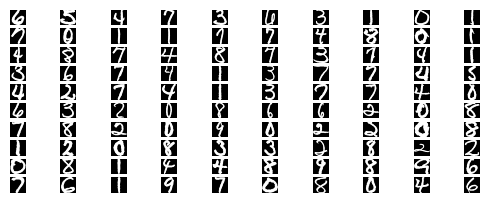

In [15]:
for i in range(100):
    X_train_ = X_train[i,:].reshape(16, 16)
    X_train_ = np.abs(255.0 - X_train_)
    plt.subplot(20, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_.astype('uint8'), cmap='Greys')
    plt.axis('off')

### Training

We are NOT going to use the stochastic version of the gradient descent method. Therefore, we set the `batch_size` to `None`.

In [20]:
#classifier = Softmax() # using Softmax
classifier = SVM()     # using linear SVM
loss_hist = classifier.train(np.vstack((X_train, X_test)), np.hstack((Y_train, Y_test)), learning_rate=1e-6, reg=1e-1, batch_size=None, num_iters=2000, verbose_step=1000)

iteration 0 / 2000: loss 19.419819


iteration 1000 / 2000: loss 0.276519
iteration 1999 / 2000: loss 0.216839


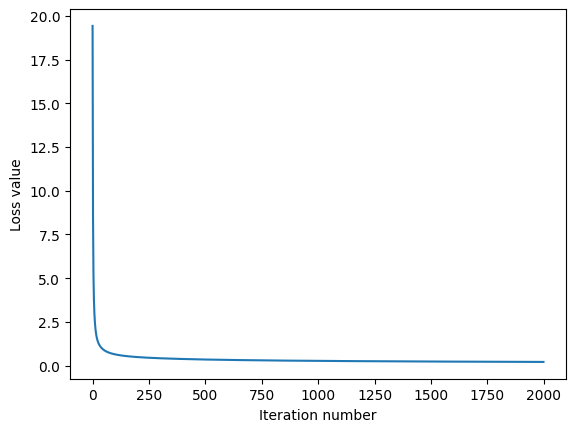

In [21]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Testing

In [22]:
Y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == Y_train_pred), ))

Y_test_pred = classifier.predict(X_test)
print('testing accuracy: %f' % (np.mean(Y_test == Y_test_pred), ))

training accuracy: 0.957756
testing accuracy: 0.925760


### Save the matrix

All we need is only the `W` matrix. We need to store the flattended version of the matrix, thus, we add a comma at every end of a line.

In [23]:
np.savetxt('W.txt', classifier.W.transpose(), delimiter='\n', fmt='%.8f', newline='\n')

Copy this matrix to the Arduino PROGMEM, inside a file named `matrix.h`.